In [210]:
import warnings
import umap
import torch

import pandas as pd
import networkx as nx
import numpy as np

from tqdm import tqdm
from sklearn import decomposition, preprocessing, metrics, manifold
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter
from scipy import stats
from scipy.spatial import distance
from itertools import combinations
from annoy import AnnoyIndex

from IPython.display import display, Markdown

from torch.nn import functional as F

from news_vec.encoder import read_preds

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [28]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [29]:
df, embeds = read_preds('../data/ava-lr/')

100%|██████████| 143/143 [00:09<00:00, 15.29it/s]


In [30]:
df.label.unique()

array(['bloomberg.com.0', 'washingtonpost.com.0', 'huffingtonpost.com.1',
       'npr.org.1', 'cnn.com.0', 'wsj.com.1', 'dailykos.com.0',
       'breitbart.com.0', 'nytimes.com.1', 'npr.org.0', 'apnews.com.1',
       'buzzfeed.com.1', 'dailycaller.com.1', 'washingtonpost.com.1',
       'buzzfeed.com.0', 'msnbc.com.1', 'cnn.com.1', 'bloomberg.com.1',
       'thehill.com.0', 'breitbart.com.1', 'foxnews.com.0',
       'apnews.com.0', 'foxnews.com.1', 'dailycaller.com.0', 'wsj.com.0',
       'thehill.com.1', 'msnbc.com.0', 'nytimes.com.0', 'dailykos.com.1',
       'huffingtonpost.com.0'], dtype=object)

In [31]:
embeds.shape

(142980, 512)

In [32]:
dr = decomposition.TruncatedSVD(10)
embedding = dr.fit_transform(embeds[df.index])

In [33]:
dr.explained_variance_ratio_

array([0.212812  , 0.11161775, 0.15162323, 0.0929866 , 0.08115435,
       0.07091691, 0.05424378, 0.03749863, 0.0264721 , 0.02552767],
      dtype=float32)

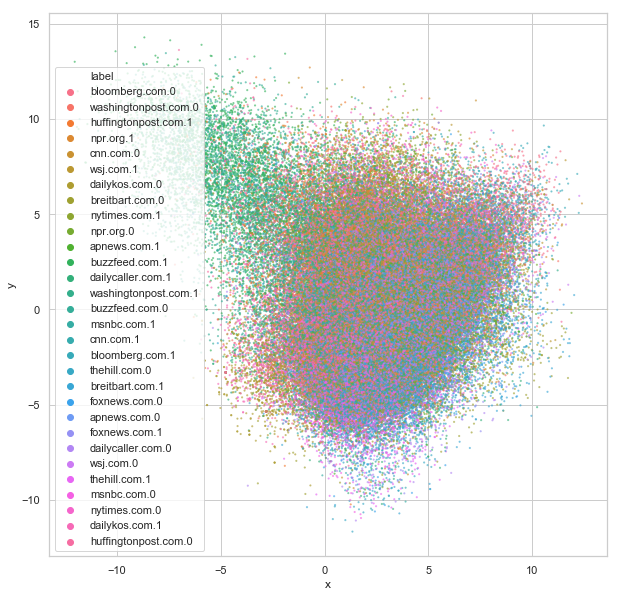

In [34]:
points = df.copy()
points['x'] = embedding[:,1]
points['y'] = embedding[:,2]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x',
    y='y',
    data=points,
    s=2,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

In [253]:
pdf = df.copy()
pdf['tokens_key'] = pdf.clf_tokens.apply(lambda ts: tuple(ts))
pdf = pdf.drop_duplicates('tokens_key')

dr = umap.UMAP(metric='cosine', verbose=True)
UMAP_EMBEDDING = dr.fit_transform(embeds[pdf.index])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


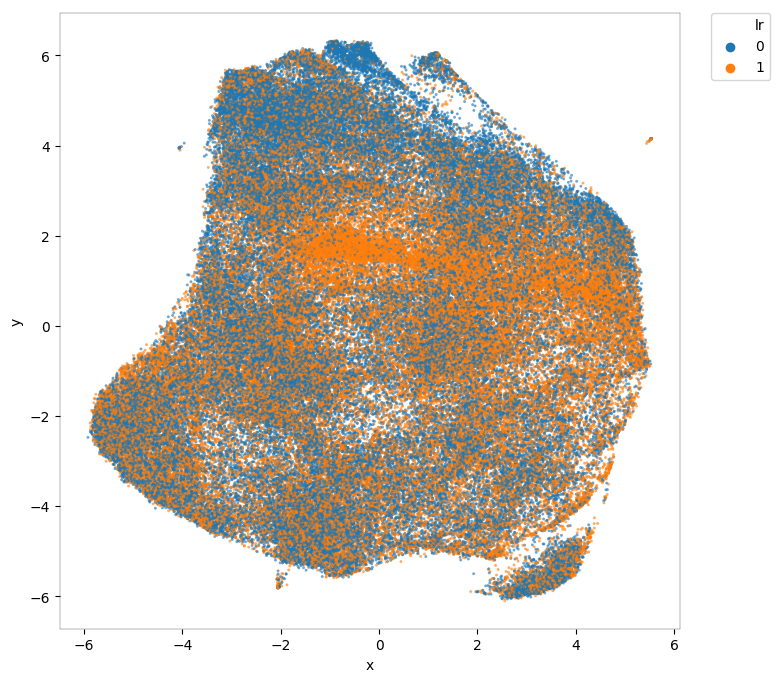

In [256]:
UMAP_POINTS = pdf.copy()
UMAP_POINTS['x'] = UMAP_EMBEDDING[:,0]
UMAP_POINTS['y'] = UMAP_EMBEDDING[:,1]

plt.figure(figsize=(8,8), dpi=100)

sns.scatterplot(
    x='x',
    y='y',
#     data=UMAP_POINTS[(UMAP_POINTS.domain=='apnews.com')],
    data=UMAP_POINTS,
    s=2,
    edgecolor=None,
    alpha=0.5,
    hue='lr',
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [64]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], 1)

In [72]:
df_train = df[df.split=='test']

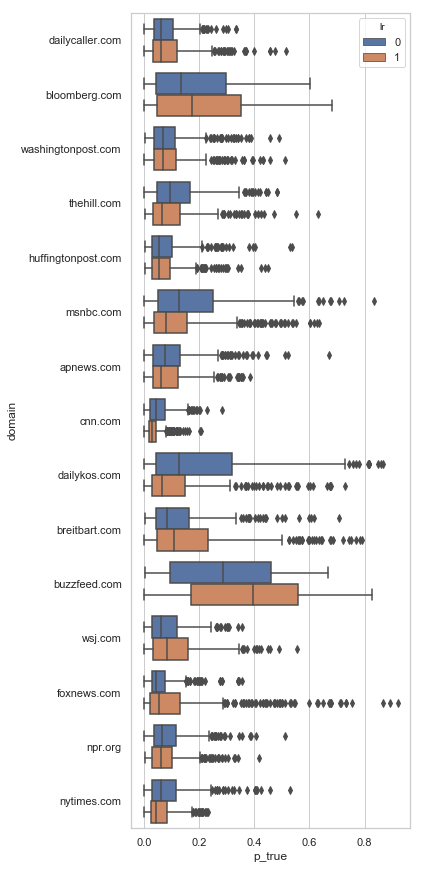

In [73]:
plt.figure(figsize=(5,15))
sns.boxplot(y='domain', x='p_true', data=df_train, hue='lr')

In [211]:
idx = AnnoyIndex(embeds.shape[1])

for i, v in tqdm(enumerate(embeds)):
    idx.add_item(i, v)
    
idx.build(20)

142980it [00:10, 13055.79it/s]


True

In [246]:
total_dv = embeds[df[df.lr==0].index].mean(0) - embeds[df[df.lr==1].index].mean(0)

In [249]:
domain = 'apnews.com'

dv = (
    embeds[df[(df.lr==0)&(df.domain==domain)].index].mean(0) -
    embeds[df[(df.lr==1)&(df.domain==domain)].index].mean(0)
)

In [251]:
for i in idx.get_nns_by_vector(dv-total_dv, 20):
    print(df.loc[i].domain, ' '.join(df.loc[i].clf_tokens))

huffingtonpost.com prince harry and meghan markle make their first official appearance as husband and wife
dailykos.com america s favorite first couple sent a heartfelt note of gratitude to the parkland survivors
buzzfeed.com dylan farrow is pushing back after her brother moses said woody allen never assaulted her
buzzfeed.com i m obsessed with meghan markle s dad reading a picture book to learn about england
buzzfeed.com oprah said she invited meghan markle s mom to lunch at her house and gave her kumquats
washingtonpost.com matt harvey s no show might have been due to seeing adriana lima with julian edelman
dailycaller.com aretha franklin is in hospice care as celebrities send prayers to the queen of soul
washingtonpost.com the fanged faceless sea creature that washed ashore during harvey has been identified
washingtonpost.com snapchat s maps displayed an anti semitic label for new york city it says it was vandalized
buzzfeed.com facebook called this cambridge analytica researcher a 